In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

A função recebe dois parâmetros: o tamanho do filtro (size) e o desvio padrão da distribuição gaussiana (sigma). O tamanho do filtro deve ser ímpar, para que haja um pixel central. O desvio padrão determina a largura da função gaussiana e, portanto, o grau de suavização do filtro.

O filtro é criado como uma matriz numpy (array) com tamanho size x size, preenchido com zeros inicialmente. Em seguida, um laço é usado para percorrer cada posição da matriz e, para cada posição (i,j), o valor do filtro é calculado usando a fórmula da função gaussiana:

�
(
�
,
�
)
=
1
2
�
�
2
�
−
(
�
−
�
�
�
�
−
1
2
)
2
+
(
�
−
�
�
�
�
−
1
2
)
2
2
�
2
f(i,j)= 
2πσ 
2
 
1
​
 e 
− 
2σ 
2
 
(i− 
2
size−1
​
 ) 
2
 +(j− 
2
size−1
​
 ) 
2
 
​
 
 

onde $f(i,j)$ é o valor da função gaussiana na posição (i,j), $\sigma$ é o desvio padrão e size é o tamanho do filtro.

O loop também calcula a soma de todos os valores do filtro, que é usada para normalizar o filtro, de modo que a soma de todos os seus valores seja igual a 1.

Por fim, a função retorna o filtro gaussiano 2D calculado.







In [14]:
def gaussian_filter(size, sigma):
    """
    Retorna um filtro gaussiano 2D de tamanho size x size e desvio padrão sigma.
    """
    filter = np.zeros((size, size))
    center = size // 2
    sum = 0
    for i in range(size):
        for j in range(size):
            filter[i,j] = np.exp(-((i-center)**2 + (j-center)**2)/(2*sigma**2))
            sum += filter[i,j]
    filter /= sum
    return filter

In [15]:
def convolve(image, kernel):
    m, n = kernel.shape
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    filtered_image = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            filtered_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return filtered_image

In [16]:
def apply_gaussian_filter(image, size, sigma):
    """
    Aplica um filtro gaussiano 2D na imagem de entrada.
    """
    # Aplica o filtro gaussiano na imagem
    kernel = gaussian_filter(size, sigma)
    filtered_image = convolve(image, kernel)

    # plt.imshow(image, cmap='gray')
    # plt.title('Imagem original')
    # plt.show()

    # # Plota a imagem filtrada
    # plt.imshow(filtered_image, cmap='gray')
    # plt.title('Imagem filtrada')
    # plt.show()
    
    return filtered_image

In [17]:
apply_gaussian_filter(cv2.imread('grayscale_1.png', 0), 5, 1)

array([[61.81422636, 61.52873826, 60.76793704, ..., 93.79020027,
        93.17857026, 93.08980635],
       [59.50480714, 59.19379394, 58.55927541, ..., 92.90858711,
        92.28620883, 91.47582357],
       [59.83960725, 59.2702637 , 58.6679536 , ..., 91.44736766,
        91.1309482 , 90.57065749],
       ...,
       [28.0136794 , 28.06765069, 27.57633241, ..., 28.46621349,
        27.85738379, 27.18221365],
       [27.86878862, 27.52510852, 27.10224691, ..., 29.17903487,
        28.60978701, 27.66363466],
       [27.27372936, 26.71023778, 26.4384352 , ..., 29.1581062 ,
        29.06614307, 28.32567564]])

In [18]:
def calculate_gradient(image):
    """
    Calcula o gradiente da imagem utilizando Sobel.
    """
    # Define os filtros Sobel para detecção de bordas na horizontal e vertical
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    # Aplica os filtros Sobel na imagem
    grad_x = convolve(image, sobel_x)
    grad_y = convolve(image, sobel_y)

    # Calcula a magnitude e direção do gradiente
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x)

    return magnitude, direction


In [19]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    """
    Implementação do algoritmo Non-Maximum Suppression para refinar as bordas
    detectadas pelo detector de bordas de Canny.
    """
    # Define as direções das bordas em termos de ângulo
    # Considera-se 4 direções: 0, 45, 90 e 135 graus
    angle_quantization = np.round(gradient_direction / (np.pi/4)) % 4
    
    # Define as dimensões da imagem
    M, N = gradient_magnitude.shape
    
    # Cria uma matriz para armazenar as bordas finais
    non_max_suppressed = np.zeros((M,N), dtype=np.int32)
    
    # Itera sobre cada pixel da imagem, ignorando a primeira e última linha e coluna
    for i in range(1, M-1):
        for j in range(1, N-1):
            # Verifica a direção da borda
            direction = angle_quantization[i, j]
            # Verifica os gradientes na direção da borda e na direção oposta
            if direction == 0:
                before_pixel = gradient_magnitude[i, j-1]
                after_pixel = gradient_magnitude[i, j+1]
            elif direction == 1:
                before_pixel = gradient_magnitude[i-1, j+1]
                after_pixel = gradient_magnitude[i+1, j-1]
            elif direction == 2:
                before_pixel = gradient_magnitude[i-1, j]
                after_pixel = gradient_magnitude[i+1, j]
            elif direction == 3:
                before_pixel = gradient_magnitude[i-1, j-1]
                after_pixel = gradient_magnitude[i+1, j+1]
            # Verifica se o gradiente atual é o máximo nas duas direções
            if gradient_magnitude[i,j] >= before_pixel and gradient_magnitude[i,j] >= after_pixel:
                non_max_suppressed[i,j] = gradient_magnitude[i,j]
    
    return non_max_suppressed


In [20]:
def double_thresholding(image, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    """
    Implementação da etapa de double thresholding do algoritmo de Canny.
    """
    # Calcula os limiares baixo e alto com base nos percentuais especificados
    low_threshold = np.max(image) * low_threshold_ratio
    high_threshold = np.max(image) * high_threshold_ratio
    
    # Cria uma matriz para armazenar as bordas detectadas
    M, N = image.shape
    edges = np.zeros((M,N), dtype=np.int32)
    
    # Identifica os pixels que são bordas fortes (acima do limiar alto)
    strong_edges_i, strong_edges_j = np.where(image >= high_threshold)
    edges[strong_edges_i, strong_edges_j] = 255
    
    # Identifica os pixels que são bordas fracas (entre os limiares baixo e alto)
    weak_edges_i, weak_edges_j = np.where((image >= low_threshold) & (image < high_threshold))
    edges[weak_edges_i, weak_edges_j] = 50
    
    # Verifica se as bordas fracas estão conectadas às bordas fortes
    # Para isso, percorre a matriz e verifica se cada pixel de borda fraca tem algum vizinho de borda forte
    for i in range(1, M-1):
        for j in range(1, N-1):
            if edges[i,j] == 50:
                if np.max(edges[i-1:i+2, j-1:j+2]) == 255:
                    edges[i,j] = 255
                else:
                    edges[i,j] = 0
    
    # Remove as bordas fracas que não estão conectadas às bordas fortes
    weak_edges_i, weak_edges_j = np.where(edges == 50)
    edges[weak_edges_i, weak_edges_j] = 0
    
    return edges


In [21]:
def apply_canny_edge_detection(image, low_threshold, high_threshold):
    """
    Detecta bordas na imagem utilizando o algoritmo de Canny.
    """
    # Aplica o filtro gaussiano na imagem
    filtered_image = apply_gaussian_filter(image, size=5, sigma=1.4)

    # Calcula o gradiente da imagem utilizando os operadores de Sobel
    gradient_magnitude, gradient_direction = calculate_gradient(filtered_image)

    # Aplica a não-supressão de não-máximos para afinar as bordas
    suppressed_image = non_max_suppression(gradient_magnitude, gradient_direction)

    # Aplica a limiarização dupla para selecionar as bordas
    edges = double_thresholding(suppressed_image, low_threshold, high_threshold)

    # Plotar a imagem original
    plt.imshow(image, cmap='gray')
    plt.title('Imagem original')
    plt.show()

    # Plotar a imagem tratada
    plt.imshow(edges, cmap='gray')
    plt.title('Imagem com bordas detectadas')
    plt.show()

    return edges

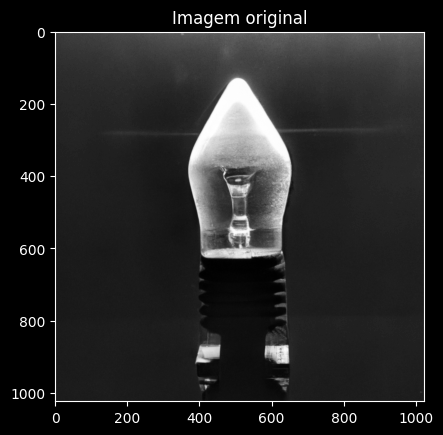

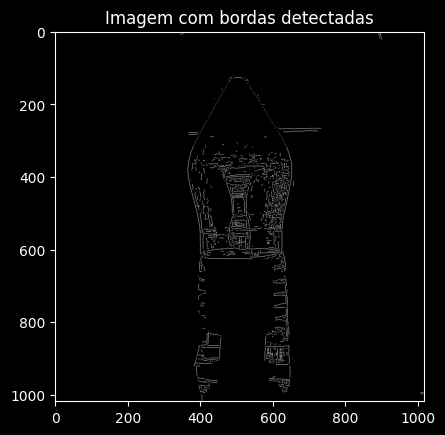

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
apply_canny_edge_detection(cv2.imread('grayscale_1.png', cv2.IMREAD_GRAYSCALE), 0.05, 0.09)

In [23]:
def sobel_detector(image):
    # Operador Sobel em x
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    
    # Operador Sobel em y
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])
    
    # Aplica a convolução com os operadores Sobel
    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)

    gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    # Normaliza a magnitude para o intervalo [0, 255]
    gradient_magnitude *= 255.0 / np.max(gradient_magnitude)
    
    # Converte a magnitude em uma matriz de imagem do tipo uint8
    gradient_image = gradient_magnitude.astype(np.uint8)

    # Plotar a imagem original
    plt.imshow(image, cmap='gray')
    plt.title('Imagem original')
    plt.show()

    # Plotar a imagem tratada
    plt.imshow(gradient_image, cmap='gray')
    plt.title('Imagem com bordas detectadas')
    plt.show()

    return gradient_image


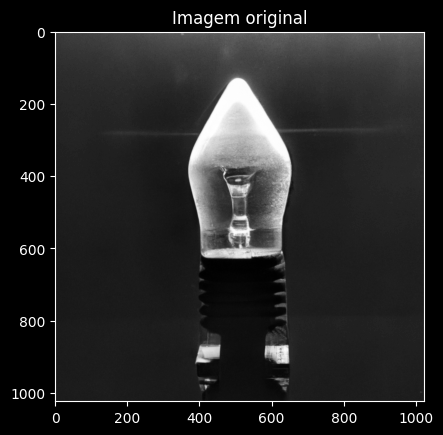

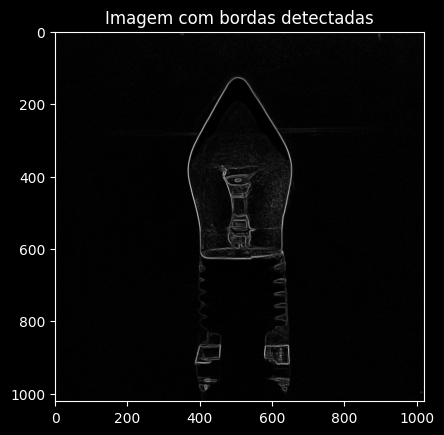

array([[47, 45, 47, ..., 29, 30, 32],
       [ 6,  7,  6, ...,  3,  3,  4],
       [ 3,  1,  1, ...,  5,  4,  2],
       ...,
       [ 3,  2,  4, ...,  4,  5,  2],
       [ 0,  3,  3, ...,  0,  5,  2],
       [ 3,  3,  2, ...,  2,  4,  4]], dtype=uint8)

In [24]:
sobel_detector(cv2.imread('grayscale_1.png', cv2.IMREAD_GRAYSCALE))

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def frei_chen_detector(image):
    # Máscaras do detector de Frei-Chen
    masks = [np.array([[1, np.sqrt(2), 1],
                       [0, 0, 0],
                       [-1, -np.sqrt(2), -1]]),
             np.array([[-1, 0, 1],
                       [-np.sqrt(2), 0, np.sqrt(2)],
                       [-1, 0, 1]]),
             np.array([[-1, -np.sqrt(2), -1],
                       [0, 0, 0],
                       [1, np.sqrt(2), 1]]),
             np.array([[1, 0, -1],
                       [np.sqrt(2), 0, -np.sqrt(2)],
                       [1, 0, -1]]),
             np.array([[0, 1, np.sqrt(2)],
                       [-1, 0, 1],
                       [-np.sqrt(2), -1, 0]]),
             np.array([[-np.sqrt(2), -1, 0],
                       [1, 0, -1],
                       [0, 1, np.sqrt(2)]]),
             np.array([[0, -1, -np.sqrt(2)],
                       [1, 0, -1],
                       [np.sqrt(2), 1, 0]]),
             np.array([[np.sqrt(2), 1, 0],
                       [-1, 0, -1],
                       [0, -1, -np.sqrt(2)]])
            ]
    
    # Aplica as máscaras para obter os gradientes aproximados
    gradient_magnitudes = []
    for mask in masks:
        gradient_magnitude = np.abs(convolve(image, mask))
        gradient_magnitudes.append(gradient_magnitude)
    
    # Encontra o menor valor de gradiente para cada pixel
    min_gradient_magnitudes = np.min(gradient_magnitudes, axis=0)
    
    # Normaliza os valores dos gradientes entre 0 e 1
    normalized_gradients = min_gradient_magnitudes / np.max(min_gradient_magnitudes)
    
    # Plota as imagens original e tratada
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Imagem Original')
    ax2.imshow(normalized_gradients, cmap='gray')
    ax2.set_title('Bordas de Frei-Chen')
    plt.show()
    
    return normalized_gradients


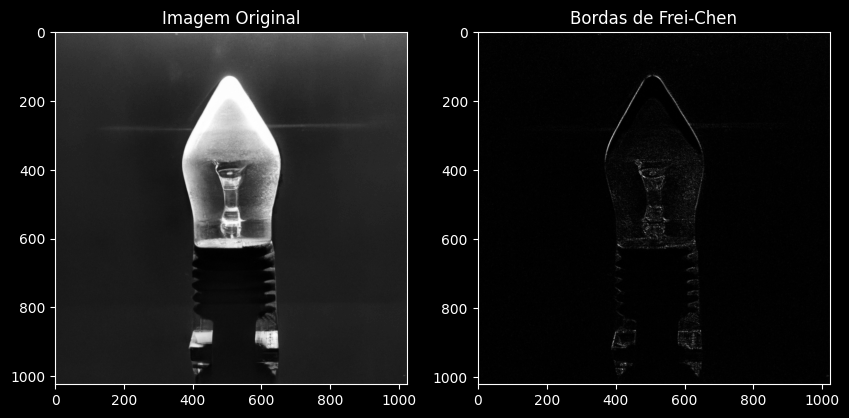

array([[4.27091005e-02, 9.47396360e-03, 4.27091005e-02, ...,
        3.66386159e-02, 5.73645468e-02, 2.41294099e-02],
       [4.48553409e-02, 1.55444482e-02, 2.19831695e-02, ...,
        7.32772317e-03, 5.18148274e-03, 1.76906887e-02],
       [2.14624043e-03, 7.36332985e-17, 5.18148274e-03, ...,
        1.98369291e-02, 3.03524232e-03, 1.25092059e-02],
       ...,
       [8.89001893e-04, 7.32772317e-03, 5.18148274e-03, ...,
        3.10888965e-02, 3.62703792e-02, 3.03524232e-03],
       [0.00000000e+00, 5.18148274e-03, 2.14624043e-03, ...,
        0.00000000e+00, 9.10572696e-03, 8.21672506e-03],
       [1.16202040e-02, 3.03524232e-03, 2.14624043e-03, ...,
        1.98369291e-02, 1.16202040e-02, 5.18148274e-03]])

In [26]:
frei_chen_detector(cv2.imread('grayscale_1.png', cv2.IMREAD_GRAYSCALE))